In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import re
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
import torch
from torch.utils.data import Dataset, DataLoader
import warnings
from transformers import pipeline, AutoTokenizer
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Project


# Dataset Cleaning


In [4]:
import re
from tqdm import tqdm
import pyarrow as pa
import pyarrow.parquet as pq
import emoji
from bs4 import BeautifulSoup
import unicodedata

In [5]:
def load_data_in_chunks(file_path, chunksize=10000, output_parquet="cleaned_data.parquet"):
    """
    Robust CSV reader with error handling for malformed files
    """
    first_chunk = True

    # Use Python's CSV reader with error handling
    try:
        # Try reading with standard parameters first
        chunk_iter = pd.read_csv(
            file_path,
            chunksize=chunksize,
            engine='python',
            on_bad_lines='warn',
            quoting=3  # QUOTE_NONE
        )

        for chunk in tqdm(chunk_iter, desc="Processing chunks"):
            try:
                # Skip empty chunks
                if len(chunk) == 0:
                    continue

                cleaned_chunk = preprocess_tweets(chunk)
                table = pa.Table.from_pandas(cleaned_chunk)

                if first_chunk:
                    pq.write_table(table, output_parquet)
                    first_chunk = False
                else:
                    with pq.ParquetWriter(output_parquet, table.schema) as writer:
                        writer.write_table(table)

            except Exception as e:
                print(f"Error processing chunk: {e}")
                continue

    except Exception as e:
        print(f"Fatal error reading file: {e}")
        return False

    print(f"Successfully processed and saved to {output_parquet}")
    return True

def preprocess_tweets(df):
    """
    Enhanced preprocessing with robust error handling
    """
    # Safely select columns
    available_cols = [col for col in ['text', 'hashtags', 'user_followers', 'date', 'is_retweet']
                     if col in df.columns]
    df = df[available_cols].copy()

    # Initialize missing columns
    for col in ['text', 'hashtags', 'is_retweet']:
        if col not in df.columns:
            df[col] = "" if col == 'text' else [] if col == 'hashtags' else False

    # Convert is_retweet safely
    df['is_retweet'] = pd.to_numeric(df['is_retweet'], errors='coerce').fillna(0).astype(bool)

    # Text processing with error handling
    df['text'] = df['text'].astype(str).apply(
        lambda x: BeautifulSoup(x, 'html.parser').get_text() if pd.notna(x) else ""
    )

    df['text'] = df['text'].apply(
        lambda x: unicodedata.normalize('NFKD', x) if pd.notna(x) else ""
    )

    df['text'] = df['text'].apply(process_emojis)

    df['text'] = df['text'].apply(
        lambda x: re.sub(r'http\S+|@\w+|[^\w\s#\U0001F300-\U0001F6FF]', '', x)
    )

    # Hashtags processing
    df['hashtags'] = df['hashtags'].apply(
        lambda x: safe_eval_hashtags(x) if pd.notna(x) else []
    )

    # Filter retweets if column exists
    if 'is_retweet' in df.columns:
        df = df[~df['is_retweet']].drop(columns=['is_retweet'], errors='ignore')

    return df

def safe_eval_hashtags(x):
    """Safely evaluate hashtag strings"""
    try:
        if isinstance(x, str) and x.startswith('['):
            return eval(x)
        return []
    except:
        return []

def process_emojis(text):
    """Robust emoji processing"""
    if not isinstance(text, str):
        return ""

    emoticon_map = {
        r':\)|:-\)|\(-:|\(:' : '[emoticon:happy]',
        r':\(|:-\(|\)-:|\):' : '[emoticon:sad]',
        r';\)|;-\)': '[emoticon:wink]',
        r':D|:-D': '[emoticon:laugh]',
    }

    for pattern, label in emoticon_map.items():
        text = re.sub(pattern, label, text)

    try:
        return emoji.demojize(text, delimiters=("[emoji:", "]"))
    except:
        return text

# Usage:
success = load_data_in_chunks(
    "/Users/farazmustafa/Documents/Capstone Project/Bitcoin_tweets.csv",
    chunksize=50000,
    output_parquet="bitcoin_cleaned.parquet"
)

Processing chunks: 449it [05:57,  1.26it/s]

Successfully processed and saved to bitcoin_cleaned.parquet


In [7]:
df = pd.read_parquet("/Users/farazmustafa/Documents/Capstone Project/bitcoin_cleaned.parquet")

print("Basic Stats:")
print(df.describe())

Basic Stats:
        text hashtags user_followers   date
count   2650     2650            109     25
unique    14     2650             51     17
top     None       []      'altcoin'  False
freq    2633        1             30      8


In [8]:
pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

In [9]:
print(df['date'].head())
print(df['hashtags'].head())
print(df.dtypes)
print(f"NaN values in date column: {df['date'].isna().sum()}")
print(f"NaN values in hashtags column: {df['hashtags'].isna().sum()}")

Inbox me                                                                                                                                                                                                                               I'm always available for hacking. #access #automation #online #btc    #bitcoincash #cryptocurrency #bch #ripple #xrp #monero #bitcoincashbch #ripplexrp #moneroxmr #complaint #xmr"  "['access'                                                                                        'automation'         'online'   'btc'           'bitcoincash'   'cryptocurrency'   'bch'                'ripple'                                                                                                                                                                                                                                                         False
#pionex #Bitstamp #Cryptocom #Exodus #Mycelium #Trezor #Electrum #WasabiWallet #Opolo #Cobo #ShiftCrypto #Ledger #Bitcoin #

In [10]:
# Convert date column to datetime and check for successful conversion
df['date'] = pd.to_datetime(df['date'], errors='coerce')
print(f"Number of NaT values after conversion: {df['date'].isna().sum()}")
print(f"Valid date range: {df['date'].min()} to {df['date'].max()}")


Number of NaT values after conversion: 25
Valid date range: NaT to NaT


In [11]:
print(f"Dataset Summary:")
print(f"Total tweets: {len(df)}")
print(f"Columns: {df.columns.tolist()}")

Dataset Summary:
Total tweets: 25
Columns: ['text', 'hashtags', 'user_followers', 'date']


In [12]:
# Check a few hashtag entries
print(df['hashtags'].head(10))

# Test parsing a single entry
import ast
sample = df['hashtags'].dropna().iloc[0]
print(f"Original: {sample}")
try:
    parsed = ast.literal_eval(sample)
    print(f"Parsed: {parsed}, Type: {type(parsed)}")
except:
    print("Parsing failed")


Inbox me                                                                                                                                                                                                                               I'm always available for hacking. #access #automation #online #btc    #bitcoincash #cryptocurrency #bch #ripple #xrp #monero #bitcoincashbch #ripplexrp #moneroxmr #complaint #xmr"  "['access'                                                                                        'automation'                                                                        'online'             'btc'                'bitcoincash'   'cryptocurrency'   'bch'                'ripple'                                                                                                                                                                                                                                             []
#pionex #Bitstamp #Cryptocom #Exodus #Mycelium #Trezor #Elec

In [14]:
from wordcloud import WordCloud

def generate_wordcloud(df):
    """Visualize frequent terms"""
    text = ' '.join(df['text'].astype(str))
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.savefig('wordcloud.png', bbox_inches='tight')
    plt.show()

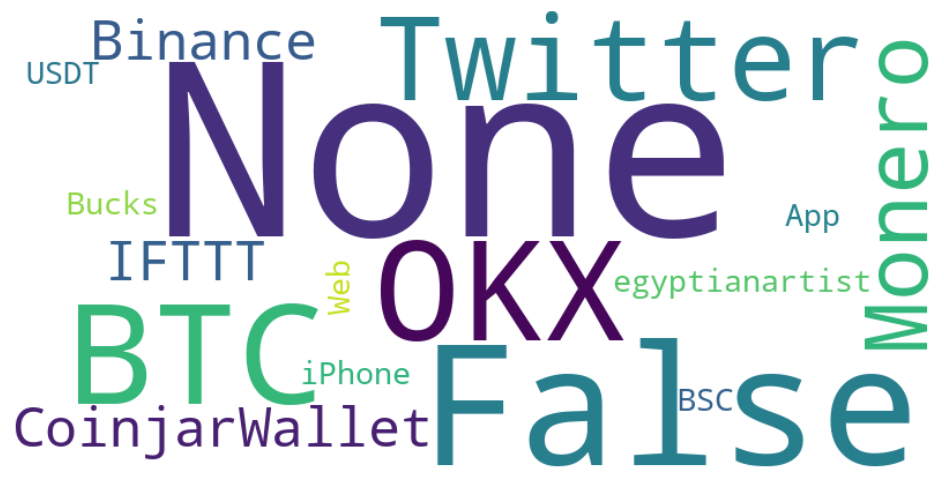

In [15]:
generate_wordcloud(df)

In [16]:
def plot_hashtags(df, hashtag_col='hashtags', top_n=10, figsize=(12, 6)):
    """Plot the most frequent hashtags in the dataset"""
    try:
        all_hashtags = []
        for tags in df[hashtag_col].dropna():
            if isinstance(tags, list):
                all_hashtags.extend(tags)
            elif isinstance(tags, str) and tags.startswith('['):
                try:
                    parsed_tags = ast.literal_eval(tags)
                    if isinstance(parsed_tags, list):
                        all_hashtags.extend(parsed_tags)
                except:
                    pass

        if not all_hashtags:
            print("No hashtags found in the dataset")
            return

        hashtag_counts = Counter(all_hashtags).most_common(top_n)
        tags, counts = zip(*hashtag_counts)

        plt.figure(figsize=figsize)
        plt.bar(tags, counts, color='skyblue')
        plt.title(f'Top {top_n} Hashtags in Bitcoin Tweets')
        plt.xlabel('Hashtag')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('top_hashtags.png')
        plt.show()

    except Exception as e:
        print(f"Error plotting hashtags: {e}")


In [17]:
plot_hashtags(df)

No hashtags found in the dataset


# Model Training

In [18]:
# 2.1 Load pretrained model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline("sentiment-analysis",
                     model=model_name,
                     tokenizer=tokenizer,
                     device=0 if torch.cuda.is_available() else -1)

Device set to use cpu


In [19]:
# 2.2 Sample subset for testing
sample_size = min(1000, len(df))
sample_df = df.sample(sample_size, random_state=42).copy()


In [20]:
# 2.3 Batch processing function
def analyze_sentiment(texts, batch_size=32):
    results = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        try:
            results.extend(classifier(batch))
        except Exception as e:
            print(f"Error on batch {i}: {e}")
            results.extend([{'label':'ERROR', 'score':0}] * len(batch))
    return results

In [21]:
# 2.4 Run analysis
sentiments = analyze_sentiment(sample_df['text'].tolist())


In [22]:
# 2.5 Add to DataFrame
sample_df['sentiment'] = [s['label'] for s in sentiments]
sample_df['confidence'] = [s['score'] for s in sentiments]

In [23]:
# Save results
sample_df.to_parquet("sentiment_results.parquet")
print("Sample results saved!")

Sample results saved!


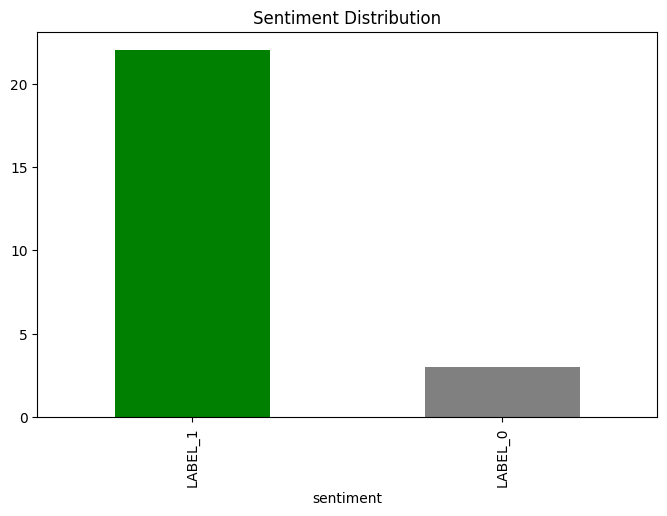

In [24]:
# 3.1 Sentiment Distribution
plt.figure(figsize=(8,5))
sample_df['sentiment'].value_counts().plot(kind='bar', color=['green', 'gray', 'red'])
plt.title("Sentiment Distribution")
plt.savefig('sentiment_dist.png')
plt.show()